In [37]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets

In [38]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

In [39]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [40]:
#Dimensões do modelo:
n = 4 #Variáveis de estado
r = 1 #Entradas de controle
l = 1 #Entradas de distúrbio
m = 3 #Saídas

In [41]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf = 1.40071 #freq. de exitação das ondas [rad/s]
A0 = 2.0 #Altura das ondas [m]
Cg = 500.0 #Momento de restituição do giroscópio [N.m]
Bg = 2500.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

Representação em Espaço de Estados do Modelo Linearizado:

In [42]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C:
C = sp.Matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

#Matriz D:
D = sp.Matrix([[0],[0],[0]])


In [43]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)

In [44]:
E

Matrix([
[               0],
[               0],
[12.3909097110891],
[               0]])

In [73]:
#Espaço de Estados com Ω = 8000 rpm:
mod_boat1 = ct.ss(An(8000*np.pi/30),B,C,D)
mod_boat1


StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02]]), array([[0.        ],
       [0.        ],
       [0.        ],
       [0.38083148]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

Agora, com o modelo SLIT estabelecido, vamos analisar a controlabilidade e a observabilidade do sistema:

In [46]:
ct.ctrb(An(8000*np.pi/30),B)

array([[ 0.00000000e+00,  0.00000000e+00, -1.84774660e-01,
         1.75922668e+02],
       [ 0.00000000e+00,  3.80831482e-01, -3.62581544e+02,
         3.44789483e+05],
       [ 0.00000000e+00, -1.84774660e-01,  1.75922668e+02,
        -1.67287766e+05],
       [ 3.80831482e-01, -3.62581544e+02,  3.44789483e+05,
        -3.27870003e+08]])

In [47]:
np.linalg.matrix_rank(ct.ctrb(An(8000*np.pi/30),B))

4

In [48]:
ct.obsv(An(8000*np.pi/30),C)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02],
       [-2.30797515e+04,  1.81290772e+05, -1.77340254e+06,
         9.05359718e+05],
       [ 1.77604687e-01,  9.23873302e+01, -9.16118223e+02,
         4.61943606e+02],
       [-2.30797515e+04,  1.81290772e+05, -1.77340254e+06,
         9.05359718e+05],
       [ 2.19740708e+07, -1.72394742e+08,  1.68635773e+09,
      

In [49]:
np.linalg.matrix_rank(ct.obsv(An(8000*np.pi/30),C))

4

Síntese por alocação de Polos:

In [50]:
#Polos da Matriz A original:
np.linalg.eig(An(8000*np.pi/30))

(array([-9.50928098e+02+0.j       , -4.80871936e-01+3.4611418j,
        -4.80871936e-01-3.4611418j, -2.03196565e-01+0.j       ]),
 array([[-5.36555323e-07+0.j        , -2.37020339e-02-0.12225177j,
         -2.37020339e-02+0.12225177j,  7.77285344e-03+0.j        ],
        [-1.05160350e-03+0.j        , -3.37610485e-02-0.24299978j,
         -3.37610485e-02+0.24299978j,  9.79942810e-01+0.j        ],
        [ 5.10225533e-04+0.j        ,  4.34528353e-01-0.02324866j,
          4.34528353e-01+0.02324866j, -1.57941712e-03+0.j        ],
        [ 9.99999317e-01+0.j        ,  8.57291448e-01+0.j        ,
          8.57291448e-01-0.j        , -1.99121013e-01+0.j        ]]))

In [51]:
#Polinômio caracterísco da Matriz A:
p = A.charpoly()
p

PurePoly(1.0*lambda**4 + 952.093038639246*lambda**3 + (0.00128765730763755*Ω**2 + 216.453238766947)*lambda**2 + 11799.8505912531*lambda + 2359.42425472976, lambda, domain='RR[Ω]')

In [52]:
a = p.all_coeffs()
a

[1.00000000000000,
 952.093038639246,
 0.00128765730763755*Ω**2 + 216.453238766947,
 11799.8505912531,
 2359.42425472976]

In [53]:
#Matriz Q:
Q = sp.Matrix([[B, A*B, A*A*B, A*A*A*B]])
Q

Matrix([
[                0,                       0,                      -0.000220558504262905*Ω,                                                                        0.209992216521396*Ω],
[                0,       0.380831482069184,                            -362.581544337529,                                               345133.650943619 - 0.000490380440864823*Ω**2],
[                0, -0.000220558504262905*Ω,                          0.209992216521396*Ω, -0.000220558504262905*Ω*(-0.00128765730763755*Ω**2 - 12.3907042628334) - 199.88711979106*Ω],
[0.380831482069184,       -362.581544337529, 345133.650943619 - 0.000490380440864823*Ω**2,                                                   0.93376857921297*Ω**2 - 328525358.268567]])

In [54]:
#Matriz Toeplitz W:
W = sp.Matrix([[1, a[1],a[2],a[3]],[0,1,a[1],a[2]],[0,0,1,a[1]],[0,0,0,1]])
W

Matrix([
[1, 952.093038639246, 0.00128765730763755*Ω**2 + 216.453238766947,                            11799.8505912531],
[0,                1,                            952.093038639246, 0.00128765730763755*Ω**2 + 216.453238766947],
[0,                0,                                           1,                            952.093038639246],
[0,                0,                                           0,                                           1]])

In [55]:
# Polos desejados para alocação em MF
#Pretende-se manter
λ, ζ, ω_n, r, R = sp.symbols('λ ζ ω_n r R')
p_ = sp.PurePoly((λ + r) * (λ + R) * ((λ + ζ*ω_n)**2 + ω_n**2 * (1 - ζ**2)), λ)
a_ = p_.all_coeffs()
a_

[1,
 R + r + 2*ζ*ω_n,
 R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n + ω_n**2,
 2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2,
 R*r*ω_n**2]

In [56]:
k = ((Q*W).inv()).T * (sp.Matrix(a_[1:]) - sp.Matrix(a[1:]))
kn = sp.lambdify((Omega, R, ζ, ω_n, r), k)
k

Matrix([
[                                                         (1.52897933540946e-15*Ω + 56179.6959603744/Ω)*(R + r + 2*ζ*ω_n - 952.093038639246) + 5.24474320422005*(R*r*ω_n**2 - 2359.42425472976)/Ω - 4533.9444214221*(2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2 - 11799.8505912531)/Ω + 1.13502090084848e-9*(R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n - 0.00128765730763755*Ω**2 + ω_n**2 - 216.453238766947)/Ω],
[-4.676585101913e-14*R*r*ζ*ω_n + 0.211916105800409*R*r*ω_n**2 + 2.28073753801061e-11*R*r + 4.56147507602121e-11*R*ζ*ω_n - 2.3382925509565e-14*R*ω_n**2 + 4.56147507602121e-11*r*ζ*ω_n - 2.3382925509565e-14*r*ω_n**2 - 2.93680835762263e-14*Ω**2 + 2.28073753801061e-11*ω_n**2 + (6.17790679148141e-17*Ω**2 - 3.3167588621118e-8)*(R + r + 2*ζ*ω_n - 952.093038639246) - 499.999999998023],
[                                                       (1.06671987432445e-13*Ω + 64.9870822336934/Ω)*(R + r + 2*ζ*ω_n - 952.093038639246) + 365.908922514729*(R*r*ω_n**2 - 2359.42425472976)/Ω - 4.78882314435891e-11*(2*R*r*ζ*ω_n + R

In [87]:
# Polos desejados para alocação em MF com a função control.place():
kT = ct.place(An(8000*np.pi/30), Bn(), [-1.0+2.5j, -1.0-2.5j, -np.sqrt(1**2 + 2.5**2), -950.0])
kT

array([[-9.31638930e+02,  3.43001837e+03, -1.10627261e+04,
         6.82596867e+00]])

Análise do sistema em malha fechada:

In [58]:
#Matriz de Estados em MF Simbólica:
A_c = A - B*k.T
A_cn = sp.lambdify((Omega, R, ζ, ω_n, r), A_c)
A_c

Matrix([
[                                                                                                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                                                                                                                                                               0,                                                                                                                                                                                                                                                        

In [94]:
#Matriz de Estados em MF a partir do ct.place() para 8000 rpm:

A_c1 = An(8000*np.pi/30) - B*kT
A_cn1 = An(8000*np.pi/30) - Bn()*kT
A_c1

Matrix([
[                0,                 0,                 1.0,                  0],
[                0,                 0,                   0,                1.0],
[-12.3909097110891,                 0, -0.0143334662850031, -0.485187462559072],
[ 354.797434284643, -1496.67471856184,    6075.67012527663,  -954.678248937282]])

In [89]:
np.linalg.eig(A_cn1)

(array([-950.       +0.j ,   -1.       +2.5j,   -1.       -2.5j,
          -2.6925824+0.j ]),
 array([[ 5.37604199e-07+0.j        ,  4.24936516e-02+0.02959985j,
          4.24936516e-02-0.02959985j, -2.31516457e-02+0.j        ],
        [ 1.05263086e-03+0.j        ,  1.27863214e-01+0.31965803j,
          1.27863214e-01-0.31965803j, -3.47384690e-01+0.j        ],
        [-5.10723989e-04+0.j        , -1.16493265e-01+0.07663428j,
         -1.16493265e-01-0.07663428j,  6.23377139e-02+0.j        ],
        [-9.99999316e-01+0.j        , -9.27008298e-01+0.j        ,
         -9.27008298e-01-0.j        ,  9.35361902e-01+0.j        ]]))

In [61]:
(A_c1).charpoly()

PurePoly(1.0*lambda**4 + 955.0*lambda**3 + 4763.25000000002*lambda**2 + 12609.2500000001*lambda + 20662.5000000001, lambda, domain='RR')

Simulação do Sistema Controlado:

In [90]:
def mod_boat_PP_sim(Omega, R, ζ, ω_n, r):
    mod_boat_MF = ct.ss(A_cn, E,
                         -kn(Omega, R, ζ, ω_n, r).T, np.array([[0]]))
    ts = np.linspace(0, 20, 1001)
    w = np.linspace(0.1, 0.1, 1001)
    x0 = [(15*np.pi/180), 0.0, 0.0, 0.0]
    t, y, x = ct.forced_response(mod_boat_MF, U=0, T=ts, X0=x0, return_x=True)
    return (t, y, x)
    

In [91]:
def update_plot_sim(Omega, R, ζ, ω_n, r):
    t, u, x = mod_boat_PP_sim(Omega, R, ζ, ω_n, r)
    fig, (state, control_input) = plt.subplots(
        2, 1, figsize=(5, 7), sharex=True)
    
    state.plot(t, x[0, :], color=cp['red'], label=r'$\phi$')
    state.plot(t, x[1, :], color=cp['blue'], label=r'$\theta$')
    state.plot(t, x[2, :], color=cp['green'], label=r'$\dot \phi$')
    state.plot(t, x[3, :], color=cp['turquoise'], label=r'$ \dot \theta$')
    # state.plot(t, x[:, 2], color='black', label=r'$x_3$')
    state.set_ylabel(r'$x$')
    state.set_xlabel(r'$t$')
    state.legend()

    control_input.plot(t, u, color=cp['orange'], label=r'$u$')
    control_input.set_ylabel(r'$u$')
    control_input.set_xlabel(r'$t$')
    control_input.legend()


# Create sliders
Omega_slider = widgets.FloatSlider(
    value=(8000*np.pi/30), min = 0, max=(10000*np.pi/30), step=50.0, description='Ω:')
R_slider = widgets.FloatSlider(
    value=-1009.43, min = -1050.0, max=-1000.0, step=2.0, description='R:')
ζ_slider = widgets.FloatSlider(
    value=0.71, min=0, max=1, step=0.01, description='ζ:')
ω_n_slider = widgets.FloatSlider(
    value=1.0, min=0, max=5.0, step=0.01, description='ω_n:')
r_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=5.0, step=0.01, description='r:')

# Create the interactive plot
interactive_plot_sim = interactive(
    update_plot_sim, Omega=Omega_slider, ζ=ζ_slider, ω_n=ω_n_slider, r=r_slider, R=R_slider)
output_sim = interactive_plot_sim.children[-1]
output_sim.layout.height = '600px'
interactive_plot_sim

interactive(children=(FloatSlider(value=837.7580409572781, description='Ω:', max=1047.1975511965977, step=50.0…

array([[list([<matplotlib.lines.Line2D object at 0x000001E5DC72D190>]),
        list([<matplotlib.lines.Line2D object at 0x000001E5DC793550>])]],
      dtype=object)

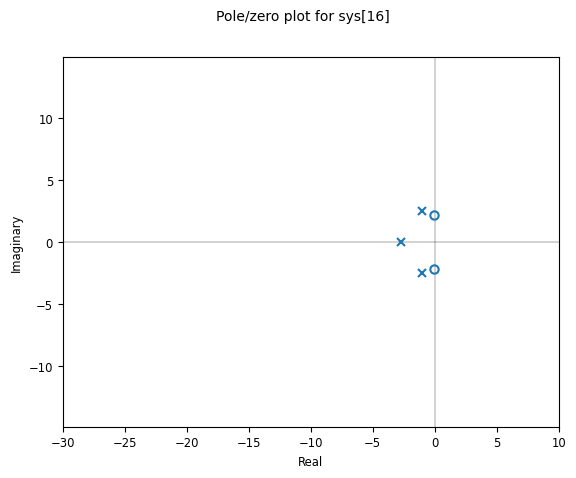

In [95]:
mod_boat_U = ct.ss(A_cn1, B, -kT, np.array([[0]]))
ct.pzmap(mod_boat_U, xlim = [-30, 10])

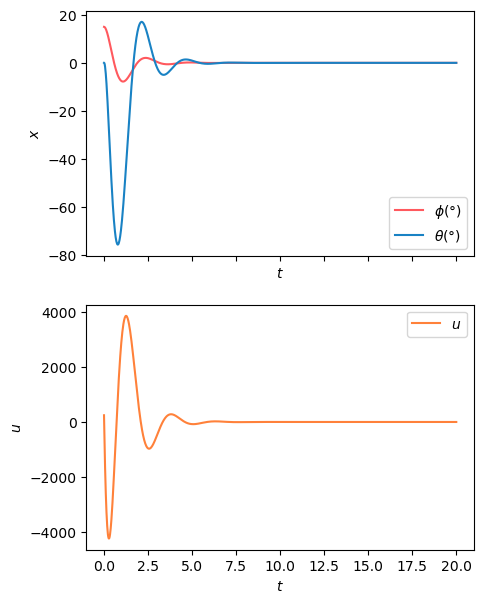

In [96]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15*np.pi/180), 0.0, 0.0, 0.0]
t, u, x = ct.forced_response(mod_boat_U, U=0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$')
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$')
control_input.legend()

In [66]:
#Parâmetros para inserção de perturbações:
Freqadm = np.sqrt(Bb/(2*g))
lda = g*2*np.pi/wf
k0 = 2*np.pi/lda 
aphm0 = A0/lda


In [67]:
mod_boat_E = ct.ss(A_cn1, E, C, np.array([[0],[0],[0]]))

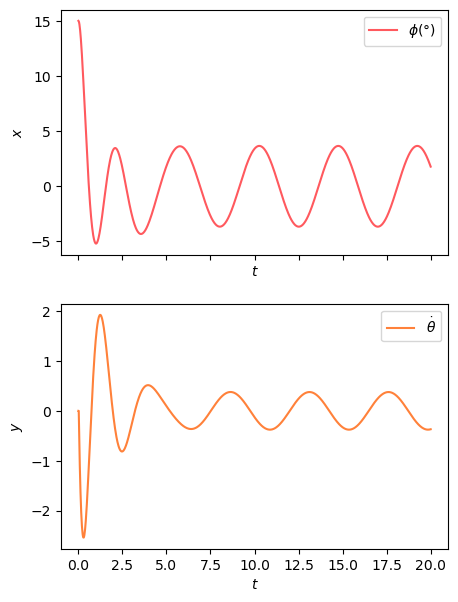

In [85]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_E, U = aphm0*np.sin(wf*ts), T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$')
#state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()

control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta$')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()

In [69]:
mod_boat_passive = ct.ss(An(8000*np.pi/30),E,C,D)

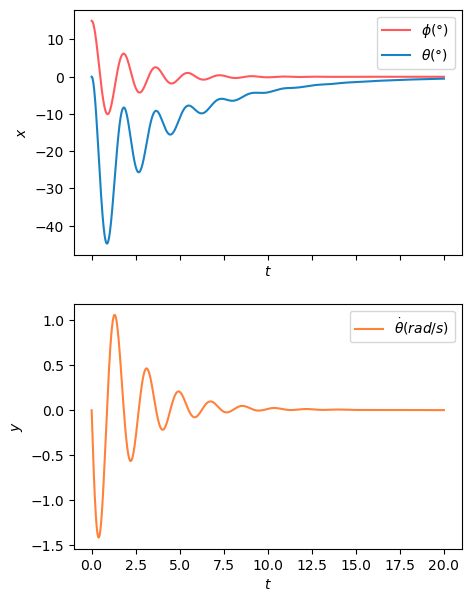

In [84]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_passive, U = 0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()


control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta (rad/s) $')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()

In [76]:
mod_boat_OFF = ct.ss(An(0*np.pi/30),E,C,D)

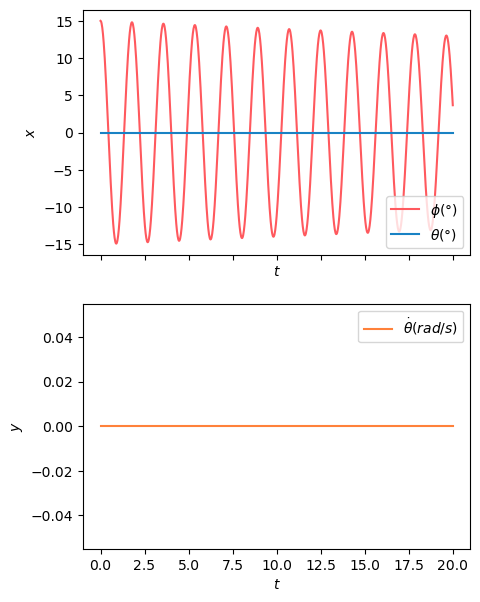

In [83]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_OFF, U = 0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()


control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta (rad/s) $')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()